## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import IdentityInterface, Function
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype import DataGrabber, Workflow, Node

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [4]:
# spm.SPMCommand().version

In [5]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [6]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [7]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']
# below info referred by datagrabber needs to be referred within infosource, selectfiles 
#info = dict(
#    func=[['RawEPI', 'subject_id', 5, ["_%04d" % i for i in range(6, 357)]]],
#    struct=[['Structural', 'subject_id', 7, '']])

# TR of functional images
TR = 2.
# Smoothing width used during preprocessing
fwhm = [8]

In [8]:
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

In [9]:
#file = '/home/matay/spmbasics/data/face_rep/Structural/sM03953_0007.img'

In [10]:
def save_as_nii(subject_id):
    import nibabel as nb
    import os
    img = nb.load(subject_id)
    nb.save(img, subject_id.replace('.img', '.nii'))
    nii_img = os.path.join(os.path.join(os.environ['HOME'], 'spmbasics/data/face_rep/Structural'), 'anat_img.nii')
    output_file = nb.save(img, nii_img)
    return nii_img

In [11]:
#save_as_nii(file)

In [12]:
#saveasnii = Node(Function(input_names = ['subject_id'], output_names = ['output'],
                        # function = save_as_nii), name = 'saveasnii')

In [13]:
anat_file = os.path.join('Structural', 'sM03953_0007.nii')
func_file = os.path.join('RawEPI', 'sM03953_0005_*.img')

templates = {'struct':anat_file,
            'func':func_file}

selectfiles = Node(SelectFiles(templates,
                               base_directory=data_dir),
                   name="selectfiles")

In [14]:
merge = Node(interface=fsl.Merge(), name="merge")
merge.inputs.dimension = "t" 
merge.inputs.output_type = 'NIFTI'

In [15]:
realigner = Node(interface=Realign(), name='realign')
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.write_mask = True
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [16]:
slicetiming = Node(interface=SliceTiming(), name = 'slicetiming')
slicetiming.inputs.num_slices = 24
slicetiming.inputs.time_repetition = 2.
slicetiming.inputs.time_acquisition = 1.92
slicetiming.inputs.slice_order = list(range(24,0,-1))
slicetiming.inputs.ref_slice = 12
slicetiming.inputs.out_prefix = 'a'

In [17]:
coregister = Node(Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]

In [18]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [19]:
segment =  Node(NewSegment(), name="newsegment")
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [20]:
normalize = Node(Normalize12(), name="normalize") 
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [21]:
smooth = Node(Smooth(), name="smooth")
smooth.inputs.fwhm = [8, 8, 8]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [22]:
art = Node(ra.ArtifactDetect(), name="art")
art.inputs.use_differences = [True, False]
art.inputs.use_norm = True
art.inputs.norm_threshold = 1
art.inputs.zintensity_threshold = 3
art.inputs.mask_type = 'spm_global'
art.inputs.parameter_source = 'SPM'
art.inputs.plot_type='svg'

In [23]:
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [24]:
def get_vox_dims(volume):
    import nibabel as nb
    if isinstance(volume, list):
        volume = volume[0]
    nii = nb.load(volume)
    hdr = nii.header
    voxdims = hdr.get_zooms()
    return [float(voxdims[0]), float(voxdims[1]), float(voxdims[2])]

In [25]:
preproc = Workflow(name='event_preproc_art')
preproc.base_dir = os.path.join(experiment_dir, working_dir)

In [26]:
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, merge, [('func', 'in_files')]),
                 (merge, datasink, [('merged_file', 'preproc.@merged_file')]),
                 (merge, realigner, [('merged_file', 'in_files')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),
                 (realigner, coregister, [('mean_image', 'target'), 
                                          ('realigned_files', 'apply_to_files')]),
                 (realigner, datasink, [('realignment_parameters', 'preproc.@realignement_parameters')]),
                 (selectfiles, coregister, [('struct', 'source')]),
                 (coregister, datasink, [('coregistered_source', 'preproc.@coregisered_source'),
                                        ('coregistered_files', 'preproc.@coregisered_files'),
                                        ('coregistered_source','preproc.@coregistered_target')]),
                 (coregister, segment, [('coregistered_source', 'channel_files')]),
                 (segment, datasink, [('bias_corrected_images', 'preproc.@bias_corrected_images'), 
                                 ('transformation_mat', 'preproc.@transformation_mat'),
                                 ('native_class_images', 'preproc.@native_class_images'),
                                 ('forward_deformation_field', 'preproc.@forward_deformation_field')]),
                 (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                 (slicetiming, normalize, [('timecorrected_files', 'apply_to_files'),
                                          (('timecorrected_files', get_vox_dims),
                                     'write_voxel_sizes')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smoothed_files')]),
                 (realigner, art, [('realignment_parameters', 'realignment_parameters')]),
                 (normalize, art, [('normalized_files', 'realigned_files')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
])

In [27]:
preproc.write_graph(graph2use='colored', format='png', dotfilename='colored_graph.dot', simple_form=True)

240521-18:02:39,956 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc_art/colored_graph.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc_art/colored_graph.png'

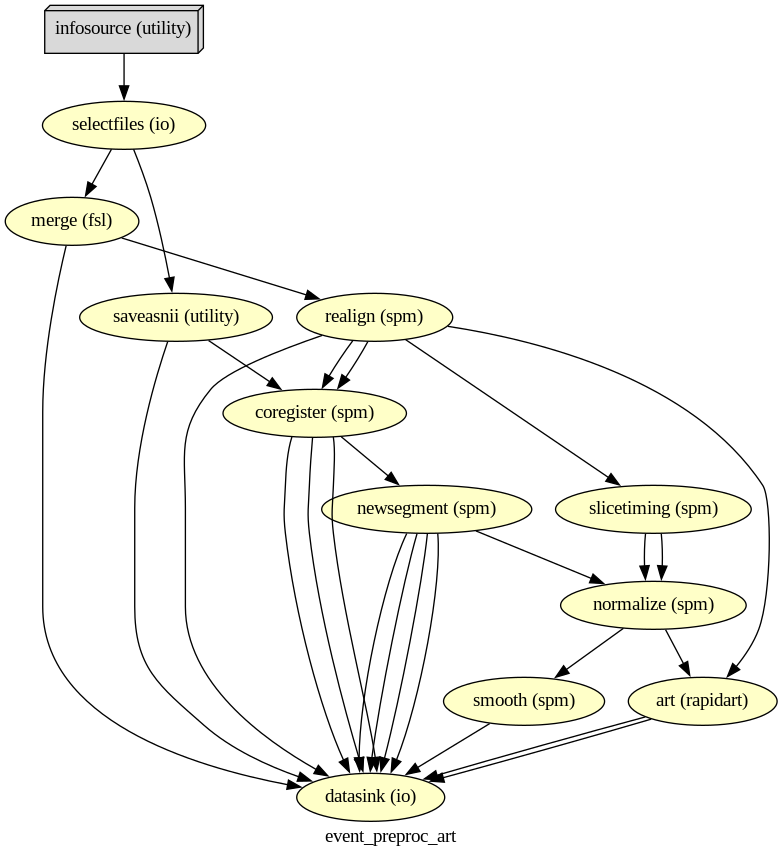

In [28]:
# Visualize the graph
from IPython.display import Image
Image(filename='/home/matay/spmbasics/data/output/workingdir/event_preproc_art/colored_graph.png', width=750)

In [28]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True, dotfilename='flat_graph.dot')

240521-18:02:44,276 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_preproc_art/flat_graph.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_preproc_art/flat_graph.png'

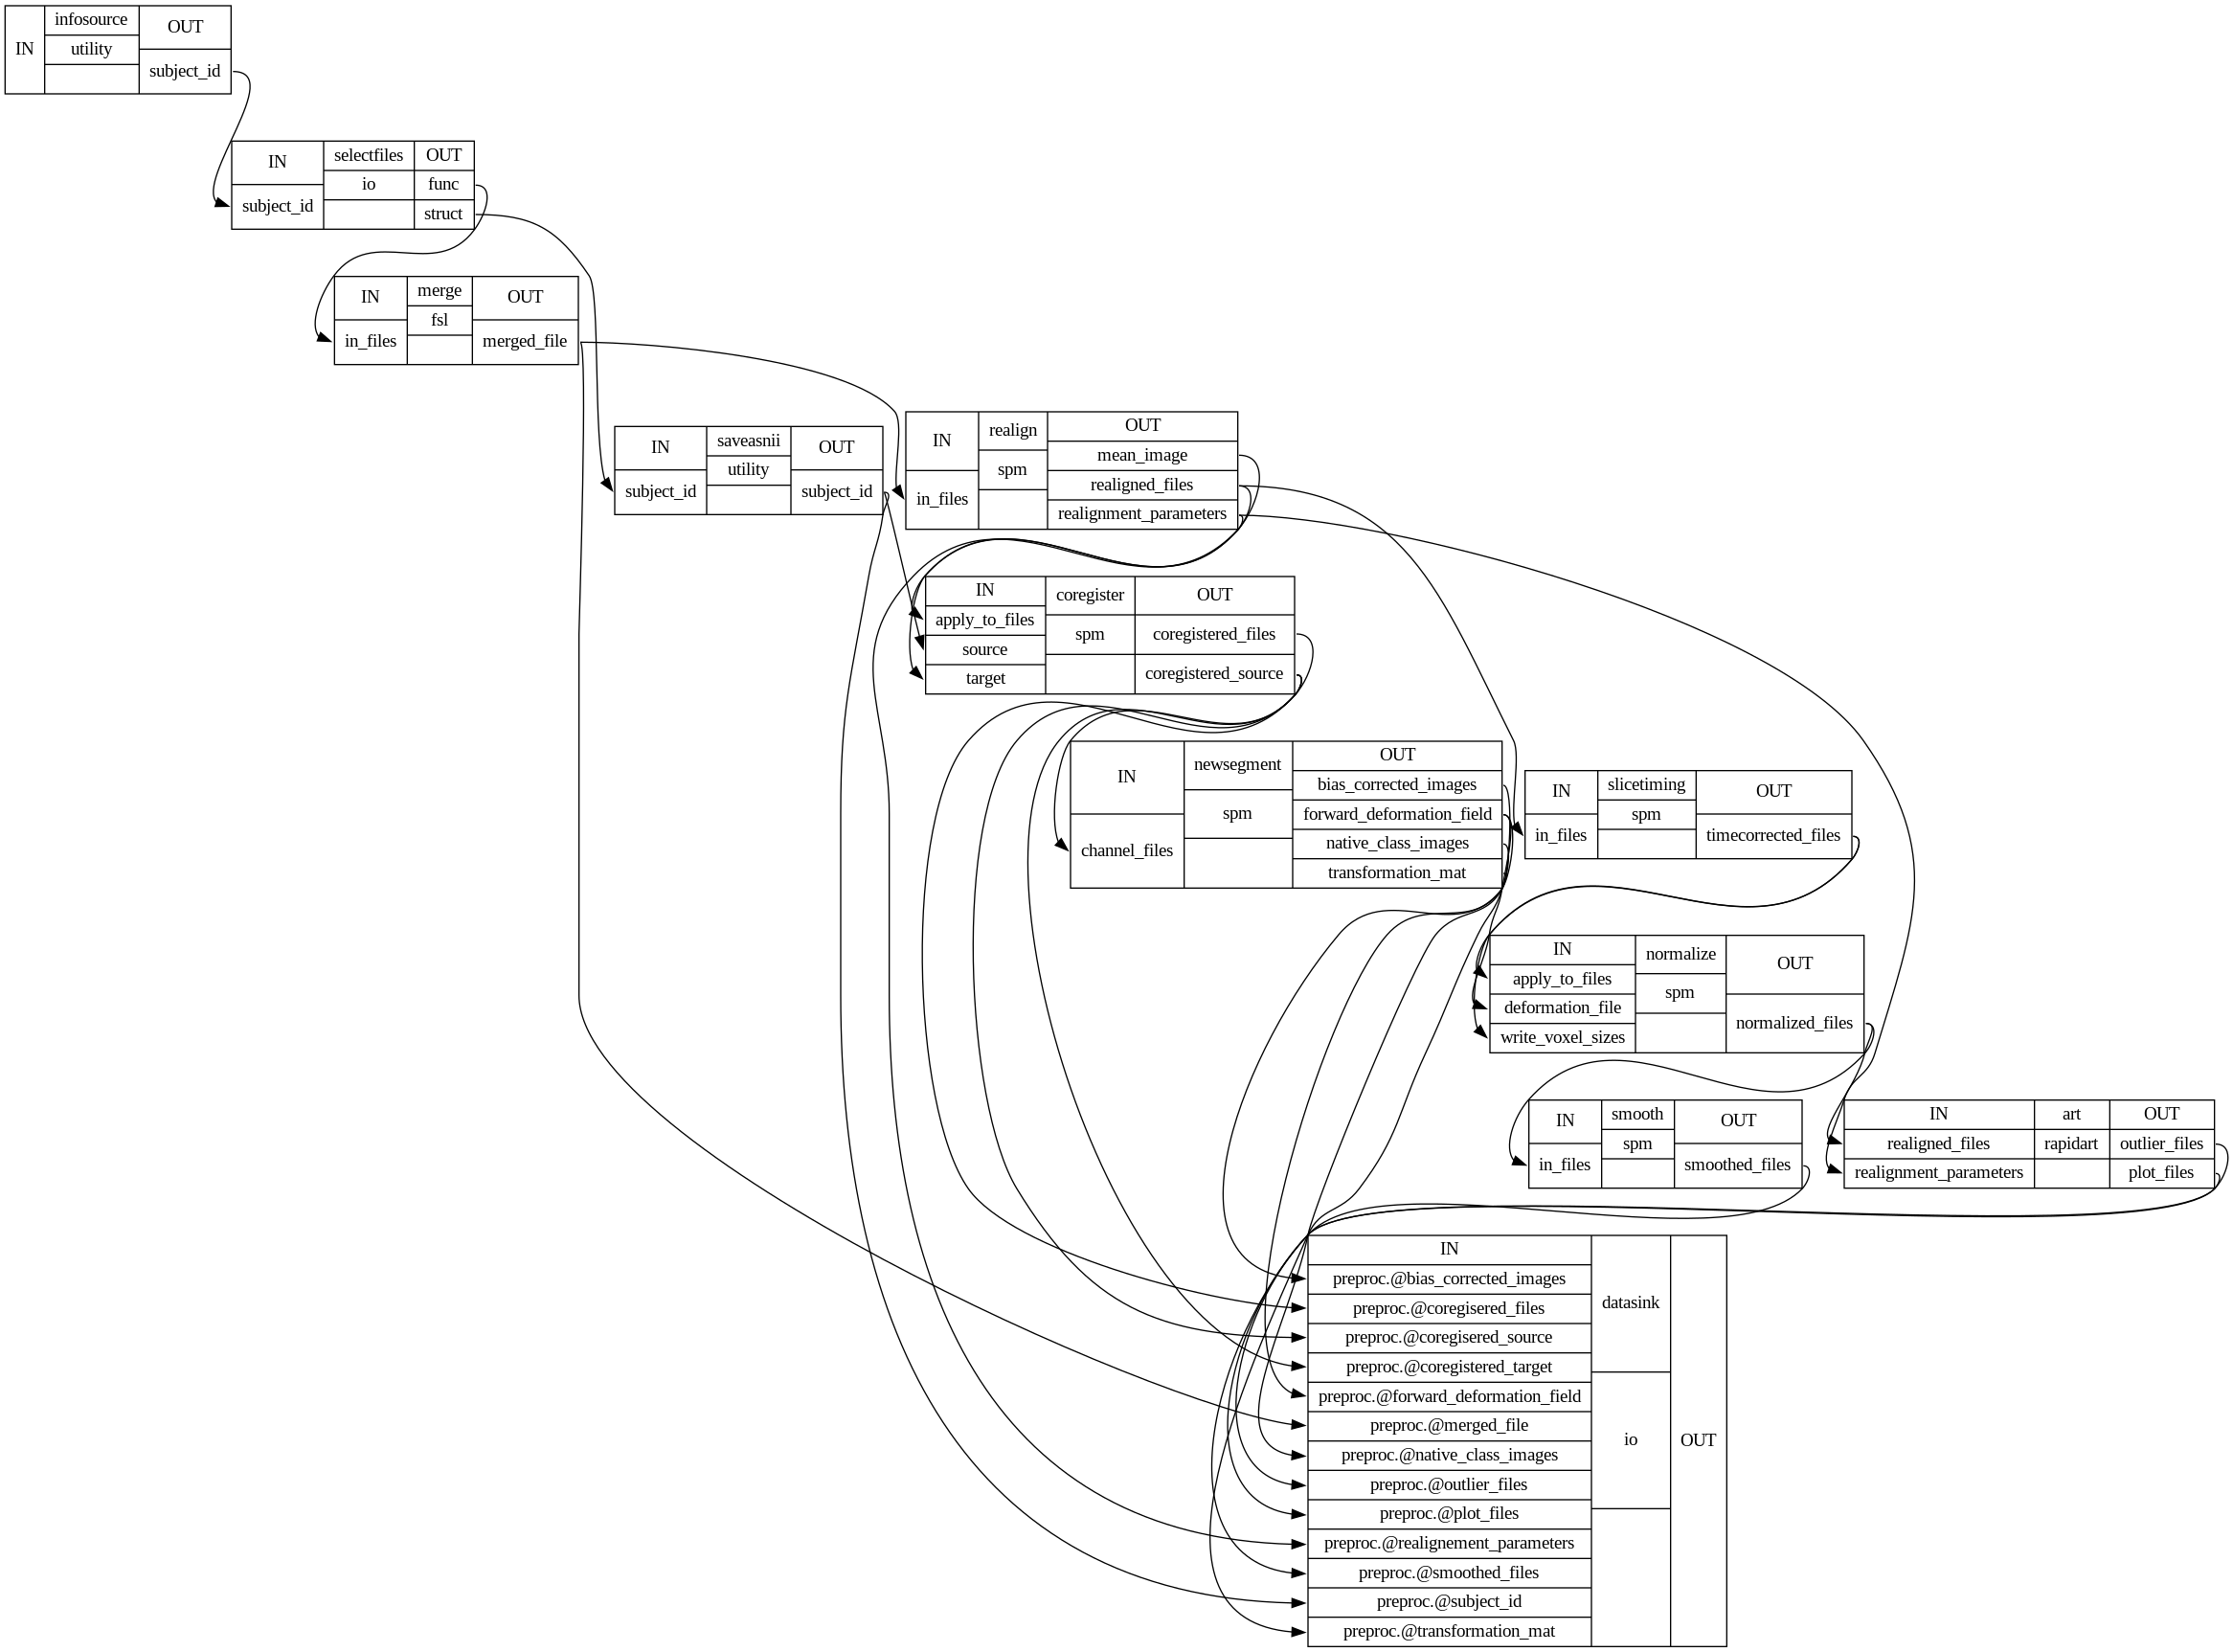

In [30]:
from IPython.display import Image
Image(filename='./spmbasics/data/output/workingdir/event_preproc_art/flat_graph_detailed.png' )

In [29]:
preproc.run()

240521-18:02:47,442 nipype.workflow INFO:
	 Workflow event_preproc_art settings: ['check', 'execution', 'logging', 'monitoring']
240521-18:02:47,451 nipype.workflow INFO:
	 Running serially.
240521-18:02:47,452 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/selectfiles".
240521-18:02:47,454 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240521-18:02:47,458 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.002407s.
240521-18:02:47,468 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.merge" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/merge".
240521-18:02:47,475 nipype.workflow INFO:
	 [Node] Cached "event_preproc_art.merge" - collecting precomputed outputs
240521-18:02:47,475 nipype.workflow INFO:
	 [Node] "event_preproc_art.merge" found cached.
240521-18:02:47,

stty: 'standard input': Inappropriate ioctl for device


240521-18:03:40,725 nipype.workflow INFO:
	 [Node] Finished "realign", elapsed time 45.731093s.
240521-18:03:40,734 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.slicetiming" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/slicetiming".
240521-18:03:40,736 nipype.workflow INFO:
	 [Node] Executing "slicetiming" <nipype.interfaces.spm.preprocess.SliceTiming>


stty: 'standard input': Inappropriate ioctl for device


240521-18:03:55,86 nipype.workflow INFO:
	 [Node] Finished "slicetiming", elapsed time 14.348975s.
240521-18:03:55,89 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.coregister" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/coregister".
240521-18:03:55,117 nipype.workflow INFO:
	 [Node] Executing "coregister" <nipype.interfaces.spm.preprocess.Coregister>


stty: 'standard input': Inappropriate ioctl for device


240521-18:04:22,996 nipype.workflow INFO:
	 [Node] Finished "coregister", elapsed time 27.878597s.
240521-18:04:22,999 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.newsegment" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/newsegment".
240521-18:04:23,2 nipype.workflow INFO:
	 [Node] Executing "newsegment" <nipype.interfaces.spm.preprocess.NewSegment>


stty: 'standard input': Inappropriate ioctl for device


240521-18:05:34,73 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 71.070489s.
240521-18:05:34,75 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.normalize" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/normalize".
240521-18:05:34,99 nipype.workflow INFO:
	 [Node] Executing "normalize" <nipype.interfaces.spm.preprocess.Normalize12>


stty: 'standard input': Inappropriate ioctl for device


240521-18:05:56,399 nipype.workflow INFO:
	 [Node] Finished "normalize", elapsed time 22.299423s.
240521-18:05:56,410 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.smooth" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/smooth".
240521-18:05:56,413 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>


stty: 'standard input': Inappropriate ioctl for device


240521-18:06:13,359 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 16.945379s.
240521-18:06:13,362 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.art" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/art".
240521-18:06:13,364 nipype.workflow INFO:
	 [Node] Executing "art" <nipype.algorithms.rapidart.ArtifactDetect>


stty: 'standard input': Inappropriate ioctl for device


240521-18:06:13,669 nipype.workflow INFO:
	 [Node] Finished "art", elapsed time 0.304026s.
240521-18:06:13,670 nipype.workflow INFO:
	 [Node] Setting-up "event_preproc_art.datasink" in "/home/matay/spmbasics/data/output/workingdir/event_preproc_art/_subject_id_M03953/datasink".
240521-18:06:13,674 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240521-18:06:13,676 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.000947s.
